### Packages & Functions

In [1]:
import numpy as np
from scipy import linalg
import cvxpy as cp
import matplotlib.pyplot as plt
import pickle

In [2]:
from quafu import QuantumCircuit
from quafu import User
from quafu import Task
from quafu import simulate
user = User("IJGwl9xqihdWU8uYGcapqmb1UdhZvmv13rEBV5PVZ1C.Qf0kjNzEzN3AzNxojIwhXZiwCNyEDN6ICZpJye.9JiN1IzUIJiOicGbhJCLiQ1VKJiOiAXe0Jye")
user.save_apitoken()

In [3]:
available_backends = user.get_available_backends()

system_name	 qubits	 status
ScQ-P10   	 10   	 None Status
ScQ-P18   	 18   	 None Status
ScQ-P136  	 136  	 Online
ScQ-P102  	 102  	 Maintenance
ScQ-P10C  	 10   	 Maintenance
ScQ-XXX   	 2    	 Offline


### Lower bound from SDP

In [4]:
def block_vec(j, n, d):
    # define ket{e_j} \otimes I_d 
    # to calculate the partial trace
    vec = np.zeros(n)
    vec[j] += 1
    return np.kron(vec, np.identity(d))

def SDP0(W, rho, obser_set):
    # SDP for NH bound
    d = len(rho)    
    n = len(obser_set)

    rhoL = np.kron(W, rho)
    S = cp.Variable((n*d, n*d), complex=True)
    Rset = []
    for j in range(n):
        Rset.append(cp.Variable((d, d), complex=True))
    RsetH = []
    for Rj in Rset:
        RsetH.append(Rj.H)

    Rvec = cp.vstack(Rset)
    RvecH = cp.hstack(RsetH)
    Xvec = cp.vstack(obser_set)
    XvecH = cp.hstack(obser_set)

    A = cp.vstack(
        [
            cp.hstack([np.identity(d), RvecH]),
            cp.hstack([Rvec, S])
        ]
    )

    Q = S - Rvec @ XvecH - Xvec @ RvecH + Xvec @ XvecH

    Sjk_set = []
    for j in range(n):
        for k in range(n):
            if j != k:
                Sjk_set.append(
                    block_vec(j, n, d) @ S @ block_vec(k, n, d).T
                )

    constraints = [
        cp.vstack(
            [
                cp.hstack([cp.real(A), -cp.imag(A)]), 
                cp.hstack([cp.imag(A), cp.real(A)])
            ]
        )
        >> 0,
        S == S.H,
        Q >> 0
    ]
        
    for Rj in Rset:
        constraints.append(
            Rj == Rj.H
        )

    for Sjk in Sjk_set:
        constraints.append(
            Sjk == Sjk.H
        )

    obj = cp.Minimize(cp.real(cp.trace(rhoL @ Q)))
    prob = cp.Problem(obj, constraints)
    # prob.solve(solver = cp.SCS, verbose=True, use_indirect=True, eps=1e-4, alpha=1)
    prob.solve(solver = cp.MOSEK)
    err = prob.value
    Rjopt = []
    for j in range(n):
        Rjopt.append(Rset[j].value)
    return [err, Rjopt]

### Analytical bounds

In [5]:
def commt(A, B):
    return A @ B - B @ A
    
def tr_norm(A):
    return sum(linalg.svdvals(A))
    
def Var(A, rho):
    return np.abs(np.trace(rho @ A @ A) - np.trace(rho @ A)**2)

def Su_tighter(obser_set, rho):
    # n = 2
    dim = len(rho)
    rhosqrt = linalg.fractional_matrix_power(rho, 1/2)
    cmt = rhosqrt @ commt(obser_set[0],obser_set[1]) @ rhosqrt
    eigvecs = linalg.eig(cmt)[1]
    bound = 0
    for j in range(dim):
        uj = eigvecs[:,j].reshape(dim,1)
        lambdaj = np.abs(np.trace(uj.conj().T @ rho @ uj))
        if lambdaj > 0:
            phij = rhosqrt @ uj / (lambdaj)**0.5
            rhoj = np.outer(phij.conj().T, phij)
            alphaj = Var(obser_set[0], rhoj) + Var(obser_set[1], rhoj)
            betaj = tr_norm(phij.conj().T @ commt(obser_set[0],obser_set[1]) @ phij)
            if alphaj > (np.abs(alphaj**2-betaj**2))**0.5:
                bound += 1/2 * lambdaj * (alphaj - (np.abs(alphaj**2-betaj**2))**0.5)
    return bound

def benchmark1(obser_set, rho):
    # tighter analytical
    n = len(obser_set)
    Cp = np.zeros((n, n))
    for j in range(n):
        for k in range(n):
            Cp[j][k] += (Su_tighter([obser_set[j], obser_set[k]], rho))**0.5
    return 1/(2*(n-1)) * linalg.norm(Cp)**2

def benchmark(obser_set, rho):
    # Ozawa
    n = len(obser_set)
    Cp = np.zeros((n, n))
    rhosqrt = linalg.fractional_matrix_power(rho, 1/2)
    for j in range(n):
        for k in range(n):
            alpha = Var(obser_set[j], rho) + Var(obser_set[k], rho)
            beta = tr_norm(rhosqrt @ commt(obser_set[j], obser_set[k]) @ rhosqrt)
            Cp[j][k] += (1/2 * (alpha - (np.abs(alpha**2-beta**2))**0.5))**0.5
    return 1/(2*(n-1)) * linalg.norm(Cp)**2

### Optimal measurement from Multiconvex Programming

In [6]:
def optPOVM(w, rho, obser_set, num, Fj):
    # generate the optimal POVM for given {Fj}
    # num: number of POVM elements
    rho_real = cp.real(rho)
    rho_imag = cp.imag(rho)
    n = len(obser_set)
    d = len(rho)
    fj_set = Fj

    # POVM_set = []
    POVM_set_real = []
    POVM_set_imag = []

    for j in range(num):
        # POVM_set.append(cp.Variable((d, d), complex=True))
        POVM_set_real.append(cp.Variable((d, d)))
        POVM_set_imag.append(cp.Variable((d, d)))
    
    err = 0
    for j in range(n):
        for m in range(num):
            Xj_real = cp.real(obser_set[j])
            Xj_imag = cp.imag(obser_set[j])
            rhoMm_real = rho_real @ POVM_set_real[m] - rho_imag @ POVM_set_imag[m]
            rhoMm_imag = rho_imag @ POVM_set_real[m] + rho_real @ POVM_set_imag[m]
            rhoMmXj_real = rhoMm_real @ Xj_real - rhoMm_imag @ Xj_imag
            err = err + w[j][j] * (
                cp.trace(rhoMm_real)*fj_set[j][m]**2 - 2*fj_set[j][m]*cp.trace(rhoMmXj_real)
            )
        err = err + w[j][j] * cp.real(cp.trace(rho @ obser_set[j] @ obser_set[j]))
    constraints = []
    # sumPOVM = np.zeros((d, d), dtype=complex)
    sumPOVM_real = np.zeros((d, d))
    sumPOVM_imag = np.zeros((d, d))
    for m in range(num):
        # sumPOVM = sumPOVM + POVM_set[m]
        sumPOVM_real = sumPOVM_real + POVM_set_real[m]
        sumPOVM_imag = sumPOVM_imag + POVM_set_imag[m]
        constraints.append(
            cp.vstack(
            [
                cp.hstack([POVM_set_real[m], -POVM_set_imag[m]]), 
                cp.hstack([POVM_set_imag[m], POVM_set_real[m]])
            ]
        )
        >> 0
        # POVM_set_real[m] + 1j*POVM_set_imag[m] >> 0
        # POVM_set[m] >> 0
        )
        # constraints.append(POVM_set[m] == POVM_set[m].H)
        constraints.append(POVM_set_real[m] == POVM_set_real[m].T)
        constraints.append(POVM_set_imag[m] == -POVM_set_imag[m].T)
    # constraints.append(
    #     sumPOVM == np.identity(d)
    # )
    constraints.append(
        sumPOVM_real == np.identity(d)
    )
    constraints.append(
        sumPOVM_imag == np.zeros((d, d))
    )
    obj = cp.Minimize(cp.abs(err))
    prob = cp.Problem(obj, constraints)
    prob.solve(solver = cp.MOSEK)
    optM = []
    for m in range(num):
        # optM.append(POVM_set[m].value)
        optM.append(POVM_set_real[m].value+1j*POVM_set_imag[m].value)
    return [prob.value, optM]

def optFj(rho, obser_set, POVM):
    # generate the optimal {Fj} for given POVM
    n = len(obser_set)
    num = len(POVM)
    Fj = np.zeros((n, num))
    for j in range(n):
        for m in range(num):
            pm = np.real(np.trace(rho @ POVM[m]))
            if pm > 1e-8:
                Fj[j][m] += np.real(np.trace(rho @ obser_set[j] @ POVM[m])) / pm
            else:
                Fj[j][m] += np.random.rand()*10
    return Fj

In [7]:
def Mul_CVX(w, rho, obser_set, num, eps = 1e-5):
    # d = len(rho)
    n = len(obser_set)
    # POVM_set_init = []
    # for m in range(num):
    #     POVM_set_init.append(np.zeros((d, d)))
    #     if m < d:
    #         POVM_set_init[m][m][m] += 1
    Fj_init = np.random.random((n, num))
    # POVM_temp = POVM_set_init
    Fj_temp = Fj_init
    err = 0
    iter = 1000
    for i in range(iter):
        [err_temp, POVM_temp] = optPOVM(w, rho, obser_set, num, Fj_temp)
        Fj_temp = optFj(rho, obser_set, POVM_temp)
        if np.abs(err_temp - err) < eps:
            break
        err = err_temp
        # print(err)
    Fj_opt = Fj_temp
    POVM_opt = POVM_temp
    return [err, Fj_opt, POVM_opt]

def Mul_CVX_rep(w, rho, obser_set, num):
    opt = Mul_CVX(w, rho, obser_set, num)
    for j in range(5):
        opt_temp = Mul_CVX(w, rho, obser_set, num)
        if opt_temp[0] < opt[0]:
            opt = opt_temp
    return opt

### Functions for the 'three-state-method'

In [8]:
def three_state(psi, obser):
    Id = np.identity(len(psi))
    psi0 = psi
    psi1 = obser @ psi / np.linalg.norm(obser @ psi)
    psi2 = (Id+obser) @ psi / np.linalg.norm((Id+obser) @ psi)
    return [ psi0, psi1, psi2 ]

def state_prep_U(psi):
    Umat = np.hstack([psi, linalg.null_space(psi.conj().T)])
    return Umat

def ReTr(rho, X, p):
    d = len(rho)
    idd = np.identity(d)
    obser3 = np.array([
        [1/2, 0],
        [0, -1/2]
    ])
    M = cp.Variable((d, d), complex=True)
    rho1 = rho
    rho2 = X @ rho @ X
    rho3 = (idd + X) @ rho @ (idd + X)
    constraints = [
        M >> 0,
        idd - M >> 0,
        M == M.H
    ]
    constraints0 = constraints + [
        cp.trace(rho1 @ M) == p[0],
        cp.trace(rho2 @ M) == p[1] * np.trace(X @ rho @ X),
        cp.trace(rho3 @ M) == p[2] * np.trace((idd + X) @ rho @ (idd + X))
    ]
    constraints1 = constraints + [
        cp.trace(rho1 @ M) == p[0],
        # cp.trace(rho2 @ M) == p[1] * np.trace(X @ rho @ X),
        cp.trace(rho3 @ M) == p[2] * np.trace((idd + X) @ rho @ (idd + X))
    ]
    if tr_norm(X-obser3) > 1e-6 and tr_norm(rho-idd/2) > 1e-6:
        constraints_List = [constraints0]
    else:
        constraints_List = [constraints1]
    rhoX = (rho @ X + X @ rho)/2
    objmin = cp.Minimize(cp.real(cp.trace(M @ rhoX)))
    objmax = cp.Maximize(cp.real(cp.trace(M @ rhoX)))
    for constr in constraints_List:
        probmin = cp.Problem(objmin, constr)
        probmax = cp.Problem(objmax, constr)
        probmin.solve(solver=cp.SCS, use_indirect=True, eps=1e-8)
        probmax.solve(solver=cp.SCS, use_indirect=True, eps=1e-8)
        if np.abs(probmin.value) != np.inf and np.abs(probmax.value) != np.inf:
            return [probmin.value, probmax.value]
    return None

In [9]:
def error(rho, X, p):
    # calculate the minimal and maximal errors based on [p1, p2, p3]
    # calculate ReTr(rho M_m X_j)
    alpha_plus_min_temp = ReTr(rho, X, p)[0]
    alpha_plus_max_temp = ReTr(rho, X, p)[1]
    alpha_minus_min_temp = np.trace(rho @ X) - alpha_plus_min_temp
    alpha_minus_max_temp = np.trace(rho @ X) - alpha_plus_max_temp
    # calculate f_j(m)
    f_plus_min_temp, f_plus_max_temp = [alpha_plus_min_temp/p[0], alpha_plus_max_temp/p[0]]
    f_minus_min_temp, f_minus_max_temp = [alpha_minus_min_temp/(1-p[0]), alpha_minus_max_temp/(1-p[0])]
    err_min, err_max = [
        np.trace(rho @ X @ X) + f_plus_min_temp**2 * p[0] + f_minus_min_temp**2 * (1-p[0]) - 2 * f_plus_min_temp * alpha_plus_min_temp - 2 * f_minus_min_temp * alpha_minus_min_temp,
        np.trace(rho @ X @ X) + f_plus_max_temp**2 * p[0] + f_minus_max_temp**2 * (1-p[0]) - 2 * f_plus_max_temp * alpha_plus_max_temp - 2 * f_minus_max_temp * alpha_minus_max_temp
    ]
    return [err_min, err_max]

### Observables

In [10]:
# Pauli operators
sigma0 = np.identity(2)
sigma1 = np.array([
    [0, 1],
    [1, 0]
])
sigma2 = np.array([
    [0, -1j],
    [1j, 0]
])
sigma3 = np.array([
    [1, 0],
    [0, -1]
])
obs1 = sigma1 / 2
obs2 = sigma2 / 2
obs3 = sigma3 / 2
obser_set = [obs1, obs2, obs3]

### Calculate bounds

In [11]:
W = np.diag(np.array([1, 1, 1]))
pList = np.arange(0, 1.01, 0.01).tolist()
SDPList = []
# MultiCVXList = []
OzawaList = []
AnalyticalList = []
for p in pList:
    rho = np.array([
        [p, 0],
        [0, 1-p]
    ])
    SDPList.append(SDP0(W, rho, obser_set)[0])
    # MultiCVXList.append(Mul_CVX_rep(W, rho, obser_set, 2)[0])
    OzawaList.append(benchmark(obser_set, rho))
    AnalyticalList.append(benchmark1(obser_set, rho))

### Settings & Parameters

In [12]:
Kexp = 10
Wexp = W
pjexp = [j/Kexp for j in range(1, Kexp)]
names = ["p=%d/10" % k for k in range(1, Kexp)]

task = Task()
task.config(backend="ScQ-P136", shots=2000, compile=False)

In [13]:
# experimental data
rhoListexp = []
Measurementexp = []
for pj in pjexp:
    rho = np.array([
        [pj, 0],
        [0, 1-pj]
    ])
    rhoListexp.append(rho)
    Measurementexp.append(Mul_CVX_rep(Wexp, rho, obser_set, 2)[2])

In [163]:
for j in range(20, 21):
    # simulation result
    p1_plus_simul = []
    p2_plus_simul = []
    p3_plus_simul = []
    err_simul = []

    # experimental result
    p1_plus_exp = []
    p2_plus_exp = []
    p3_plus_exp = []
    err_exp = []

    # raw data of the experiment
    raw_data_exp = []

    for name, pj, rho, POVM in zip(names, pjexp, rhoListexp, Measurementexp):
        # state
        psi0 = np.array([[1], [0]])
        psi1 = np.array([[0], [1]])
        rho0 = np.outer(psi0, psi0.conj().T)
        rho1 = np.outer(psi1, psi1.conj().T)
        Uprep0 = state_prep_U(psi0) # unitary to prepare psi0
        Uprep1 = state_prep_U(psi1) # unitary to prepare psi0

        # optimal measurement
        Mopt = np.linalg.eig(POVM[0])[1]

        # quantum circuit    
        measures = [0]
        cbits = [0]

        p1_plus_simul.append([])
        p2_plus_simul.append([])
        p3_plus_simul.append([])
        err_simul.append([])
        p1_plus_exp.append([])
        p2_plus_exp.append([])
        p3_plus_exp.append([])
        err_exp.append([])
        raw_data_exp.append([])
        for obser in obser_set:
            while True:
                # for |0>
                qc01 = QuantumCircuit(1)
                qc01.unitary(Uprep0, [0])
                qc01.unitary(Mopt, [0])
                qc01.measure(measures,  cbits=cbits)
                qc01.measures
                res01 = task.send(qc01, wait=True, name=name)
                if res01.counts.get("0") != None:
                    p1_plus_exp0 = res01.probabilities["0"]
                else:
                    p1_plus_exp0 = 0
                res_simul01 = simulate(qc01, output="probabilities")
                p1_plus_simul0 = res_simul01.probabilities[0]

                # for |1>
                qc11 = QuantumCircuit(1)
                qc11.unitary(Uprep1, [0])
                qc11.unitary(Mopt, [0])
                qc11.measure(measures,  cbits=cbits)
                qc11.measures
                res11 = task.send(qc11, wait=True, name=name)
                if res11.counts.get("0") != None:
                    p1_plus_exp1 = res11.probabilities["0"]
                else:
                    p1_plus_exp1 = 0
                res_simul11 = simulate(qc11, output="probabilities")
                p1_plus_simul1 = res_simul11.probabilities[0]

                # for original rho
                p1_plus_exp[-1].append(
                    pj * p1_plus_exp0 + (1-pj) * p1_plus_exp1
                    )
                p1_plus_simul[-1].append(
                    pj * p1_plus_simul0 + (1-pj) * p1_plus_simul1
                    )

                # simulate p2, p3 for obser

                # for |0>
                psi_tri0 = three_state(psi0, obser)
                Uprep02 = state_prep_U(psi_tri0[1])
                qc02 = QuantumCircuit(1)
                qc02.unitary(Uprep02, [0])
                qc02.unitary(Mopt, [0])
                qc02.measure(measures,  cbits=cbits)
                qc02.measures
                res02 = task.send(qc02, wait=True, name=name)
                if res02.counts.get("0") != None:
                    p2_plus_exp0 = res02.probabilities["0"]
                else:
                    p2_plus_exp0 = 0
                res_simul02 = simulate(qc02, output="probabilities")
                p2_plus_simul0 = res_simul02.probabilities[0]

                # for |1>
                psi_tri1 = three_state(psi1, obser)
                Uprep12 = state_prep_U(psi_tri1[1])
                qc12 = QuantumCircuit(1)
                qc12.unitary(Uprep12, [0])
                qc12.unitary(Mopt, [0])
                qc12.measure(measures,  cbits=cbits)
                qc12.measures
                res12 = task.send(qc12, wait=True, name=name)
                if res12.counts.get("0") != None:
                    p2_plus_exp1 = res12.probabilities["0"]
                else:
                    p2_plus_exp1 = 0
                res_simul12 = simulate(qc12, output="probabilities")
                p2_plus_simul1 = res_simul12.probabilities[0]

                # for original rho
                p2_plus_exp[-1].append(
                    (pj * p2_plus_exp0 * np.trace(rho0 @ obser @ obser) + (1-pj) * p2_plus_exp1 * np.trace(rho1 @ obser @ obser)) / np.trace(rho @ obser @ obser)
                )
                p2_plus_simul[-1].append(
                    (pj * p2_plus_simul0 * np.trace(rho0 @ obser @ obser) + (1-pj) * p2_plus_simul1 * np.trace(rho1 @ obser @ obser)) / np.trace(rho @ obser @ obser)
                )

                # for |0>
                psi_tri0 = three_state(psi0, obser)
                Uprep03 = state_prep_U(psi_tri0[2])
                qc03 = QuantumCircuit(1)
                qc03.unitary(Uprep03, [0])
                qc03.unitary(Mopt, [0])
                qc03.measure(measures,  cbits=cbits)
                qc03.measures
                res03 = task.send(qc03, wait=True, name=name)
                if res03.counts.get("0") != None:
                    p3_plus_exp0 = res03.probabilities["0"]
                else:
                    p3_plus_exp0 = 0
                res_simul03 = simulate(qc03, output="probabilities")
                p3_plus_simul0 = res_simul03.probabilities[0]

                # for |1>
                psi_tri1 = three_state(psi1, obser)
                Uprep13 = state_prep_U(psi_tri1[2])
                qc13 = QuantumCircuit(1)
                qc13.unitary(Uprep13, [0])
                qc13.unitary(Mopt, [0])
                qc13.measure(measures,  cbits=cbits)
                qc13.measures
                res13 = task.send(qc13, wait=True, name=name)
                if res13.counts.get("0") != None:
                    p3_plus_exp1 = res13.probabilities["0"]
                else:
                    p3_plus_exp1 = 0
                res_simul13 = simulate(qc13, output="probabilities")
                p3_plus_simul1 = res_simul13.probabilities[0]

                # for original rho
                idd = np.identity(len(obser))
                p3_plus_exp[-1].append(
                    (pj * p3_plus_exp0 * np.trace(rho0 @ (idd + obser) @ (idd + obser)) + (1-pj) * p3_plus_exp1 * np.trace(rho1 @ (idd + obser) @ (idd + obser))) / np.trace(rho @ (idd + obser) @ (idd + obser))
                )
                p3_plus_simul[-1].append(
                    (pj * p3_plus_simul0 * np.trace(rho0 @ (idd + obser) @ (idd + obser)) + (1-pj) * p3_plus_simul1 * np.trace(rho1 @ (idd + obser) @ (idd + obser))) / np.trace(rho @ (idd + obser) @ (idd + obser))
                )

                p_exp = [p1_plus_exp[-1][-1], p2_plus_exp[-1][-1], p3_plus_exp[-1][-1]]
                p_simul = [p1_plus_simul[-1][-1], p2_plus_simul[-1][-1], p3_plus_simul[-1][-1]]

                if (ReTr(rho, obser, p_exp) != None) and (p_exp[0] > 1e-6) and (p_exp[0] < 1):
                    err_exp[-1].append(error(rho, obser, p_exp))
                    err_simul[-1].append(error(rho, obser, p_simul))
                    raw_data_exp[-1].append([[res01, res11], [res02, res12], [res03, res13]])
                    break
                else:
                    del p1_plus_exp[-1][-1]
                    del p2_plus_exp[-1][-1]
                    del p3_plus_exp[-1][-1]
                    del p1_plus_simul[-1][-1]
                    del p2_plus_simul[-1][-1]
                    del p3_plus_simul[-1][-1]
    np.savez(
        'Mixed_P136_%d.npz' % j,
        p1_plus_exp = p1_plus_exp,
        p2_plus_exp = p2_plus_exp, 
        p3_plus_exp = p3_plus_exp, 
        err_exp = err_exp,
        p1_plus_simul = p1_plus_simul,
        p2_plus_simul = p2_plus_simul,
        p3_plus_simul = p3_plus_simul,
        err_simul = err_simul
        )
    savedata = open('Mixed_P136_%d.obj' % j, 'wb') 
    pickle.dump(raw_data_exp, savedata)
    savedata.close()

In [169]:
Mixed_P136_err_exp = []
Mixed_P136_err_simul = []
for j in range(1, 21):
    Mixed_P136_err_exp.append(np.load("./Mixed_P136_Batch/Mixed_P136_%d.npz" % j)["err_exp"])
    Mixed_P136_err_simul.append(np.load("./Mixed_P136_Batch/Mixed_P136_%d.npz" % j)["err_simul"])

In [170]:
Mixed_P136_errsum_exp = []
for sample in Mixed_P136_err_exp:
    Mixed_P136_errsum_exp.append([])
    for point in sample:
        Mixed_P136_errsum_exp[-1].append(np.sum(np.real(point))/2)

Mixed_P136_errsum_simul = []
for sample in Mixed_P136_err_simul:
    Mixed_P136_errsum_simul.append([])
    for point in sample:
        Mixed_P136_errsum_simul[-1].append(np.sum(np.real(point))/2)

In [171]:
Mixed_P136_errsum_exp_mean = np.array(Mixed_P136_errsum_exp).mean(axis=0)
Mixed_P136_errsum_exp_std = np.array(Mixed_P136_errsum_exp).std(axis=0)

Mixed_P136_errsum_simul_mean = np.array(Mixed_P136_errsum_simul).mean(axis=0)

In [172]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

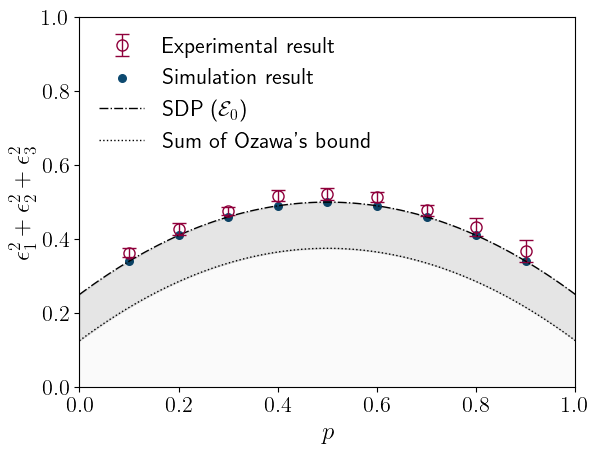

In [179]:
fig, axs = plt.subplots()

# x = thetajexp
# x = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]
# labels = ['0', '$\pi/8$', '$\pi/4$', '$3\pi/8$', '$\pi/2$']

# experimental result on quafu

# axs.scatter(pjexp, np.array(errList)[:,0], marker= 'v', s=80, facecolors='none', edgecolors='#1f77b4', label='$\mathcal{E}^{\mathrm{exp}}_{\min}$')
# axs.scatter(pjexp, np.array(errList)[:,1], marker= '^', s=80, facecolors='none', edgecolors='#1f77b4', label='$\mathcal{E}^{\mathrm{exp}}_{\max}$')

axs.errorbar(
    pjexp,
    Mixed_P136_errsum_exp_mean,
    yerr=Mixed_P136_errsum_exp_std,
    fmt='o',
    ecolor='#8F003B',
    elinewidth=1,
    capthick=1,
    ms=8,
    mfc = 'none',
    # mfc='#8F003B',
    mec='#8F003B',
    capsize=5,
    clip_on=False,
    label='Experimental result'
)

# experimental result on simulator

axs.scatter(pjexp, Mixed_P136_errsum_simul_mean, marker= 'o', s=30, color='#0D4A70', clip_on=False, label='Simulation result')
# axs.scatter(pjexp, np.array(errList_simul)[:,1], marker= 'o', s=80, facecolors='none', edgecolors='#d62728')

# axs.plot(pList, MultiCVXList_smooth, linestyle='solid', linewidth = 2, marker= 'o', mfc='none', markersize=10, markevery=6, label='Upper bound, K=5')
# axs.plot(pList, MultiCVXList_smooth1, linestyle='dotted', linewidth = 2, marker= '^', mfc='none', markersize=10, markevery=6, label='Upper bound, K=4')

# theoretical bound
axs.plot(pList, SDPList, color='black', linestyle='-.', linewidth = 1, label='SDP ($\mathcal{E}_0$)')
# axs.plot(pList, AnalyticalList, color='black', linestyle='dashed', linewidth = 1, label='Sum of Analytical')
axs.plot(pList, OzawaList, color='black', linestyle='dotted', linewidth = 1, label='Sum of Ozawa\'s bound')
# forbiden area
axs.fill_between(pList, OzawaList, SDPList, color='black', alpha=0.1)
axs.fill_between(pList, np.zeros(len(pList)), OzawaList, color='black', alpha=0.02)

xlimit = 1
ylimit = 1
plt.rcParams['text.usetex'] = True
plt.ylim([0, ylimit])
plt.xlim([0, xlimit])
# plt.xticks(np.arange(0, 1.01*xlimit, step=xlimit/5))
# plt.xticks(x, labels)
# plt.yticks(np.arange(0.8, 1.01*ylimit, step=ylimit/6))
plt.xlabel(r'$p$')
plt.ylabel(r'$\epsilon_1^2+\epsilon_2^2+\epsilon_3^2$')

#add legend to plot
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,1,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=2, frameon=False)

plt.savefig('fig.pdf', bbox_inches='tight')
plt.show()